In [1]:
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [2]:
vis=VisualTool(show=True, size=(10,10), save=True, dpi=600, save_dir="__RESULTS__/_plots")

### Overview of Construction site map

In [3]:
map=MapLoader().load("gangjin.crop2")

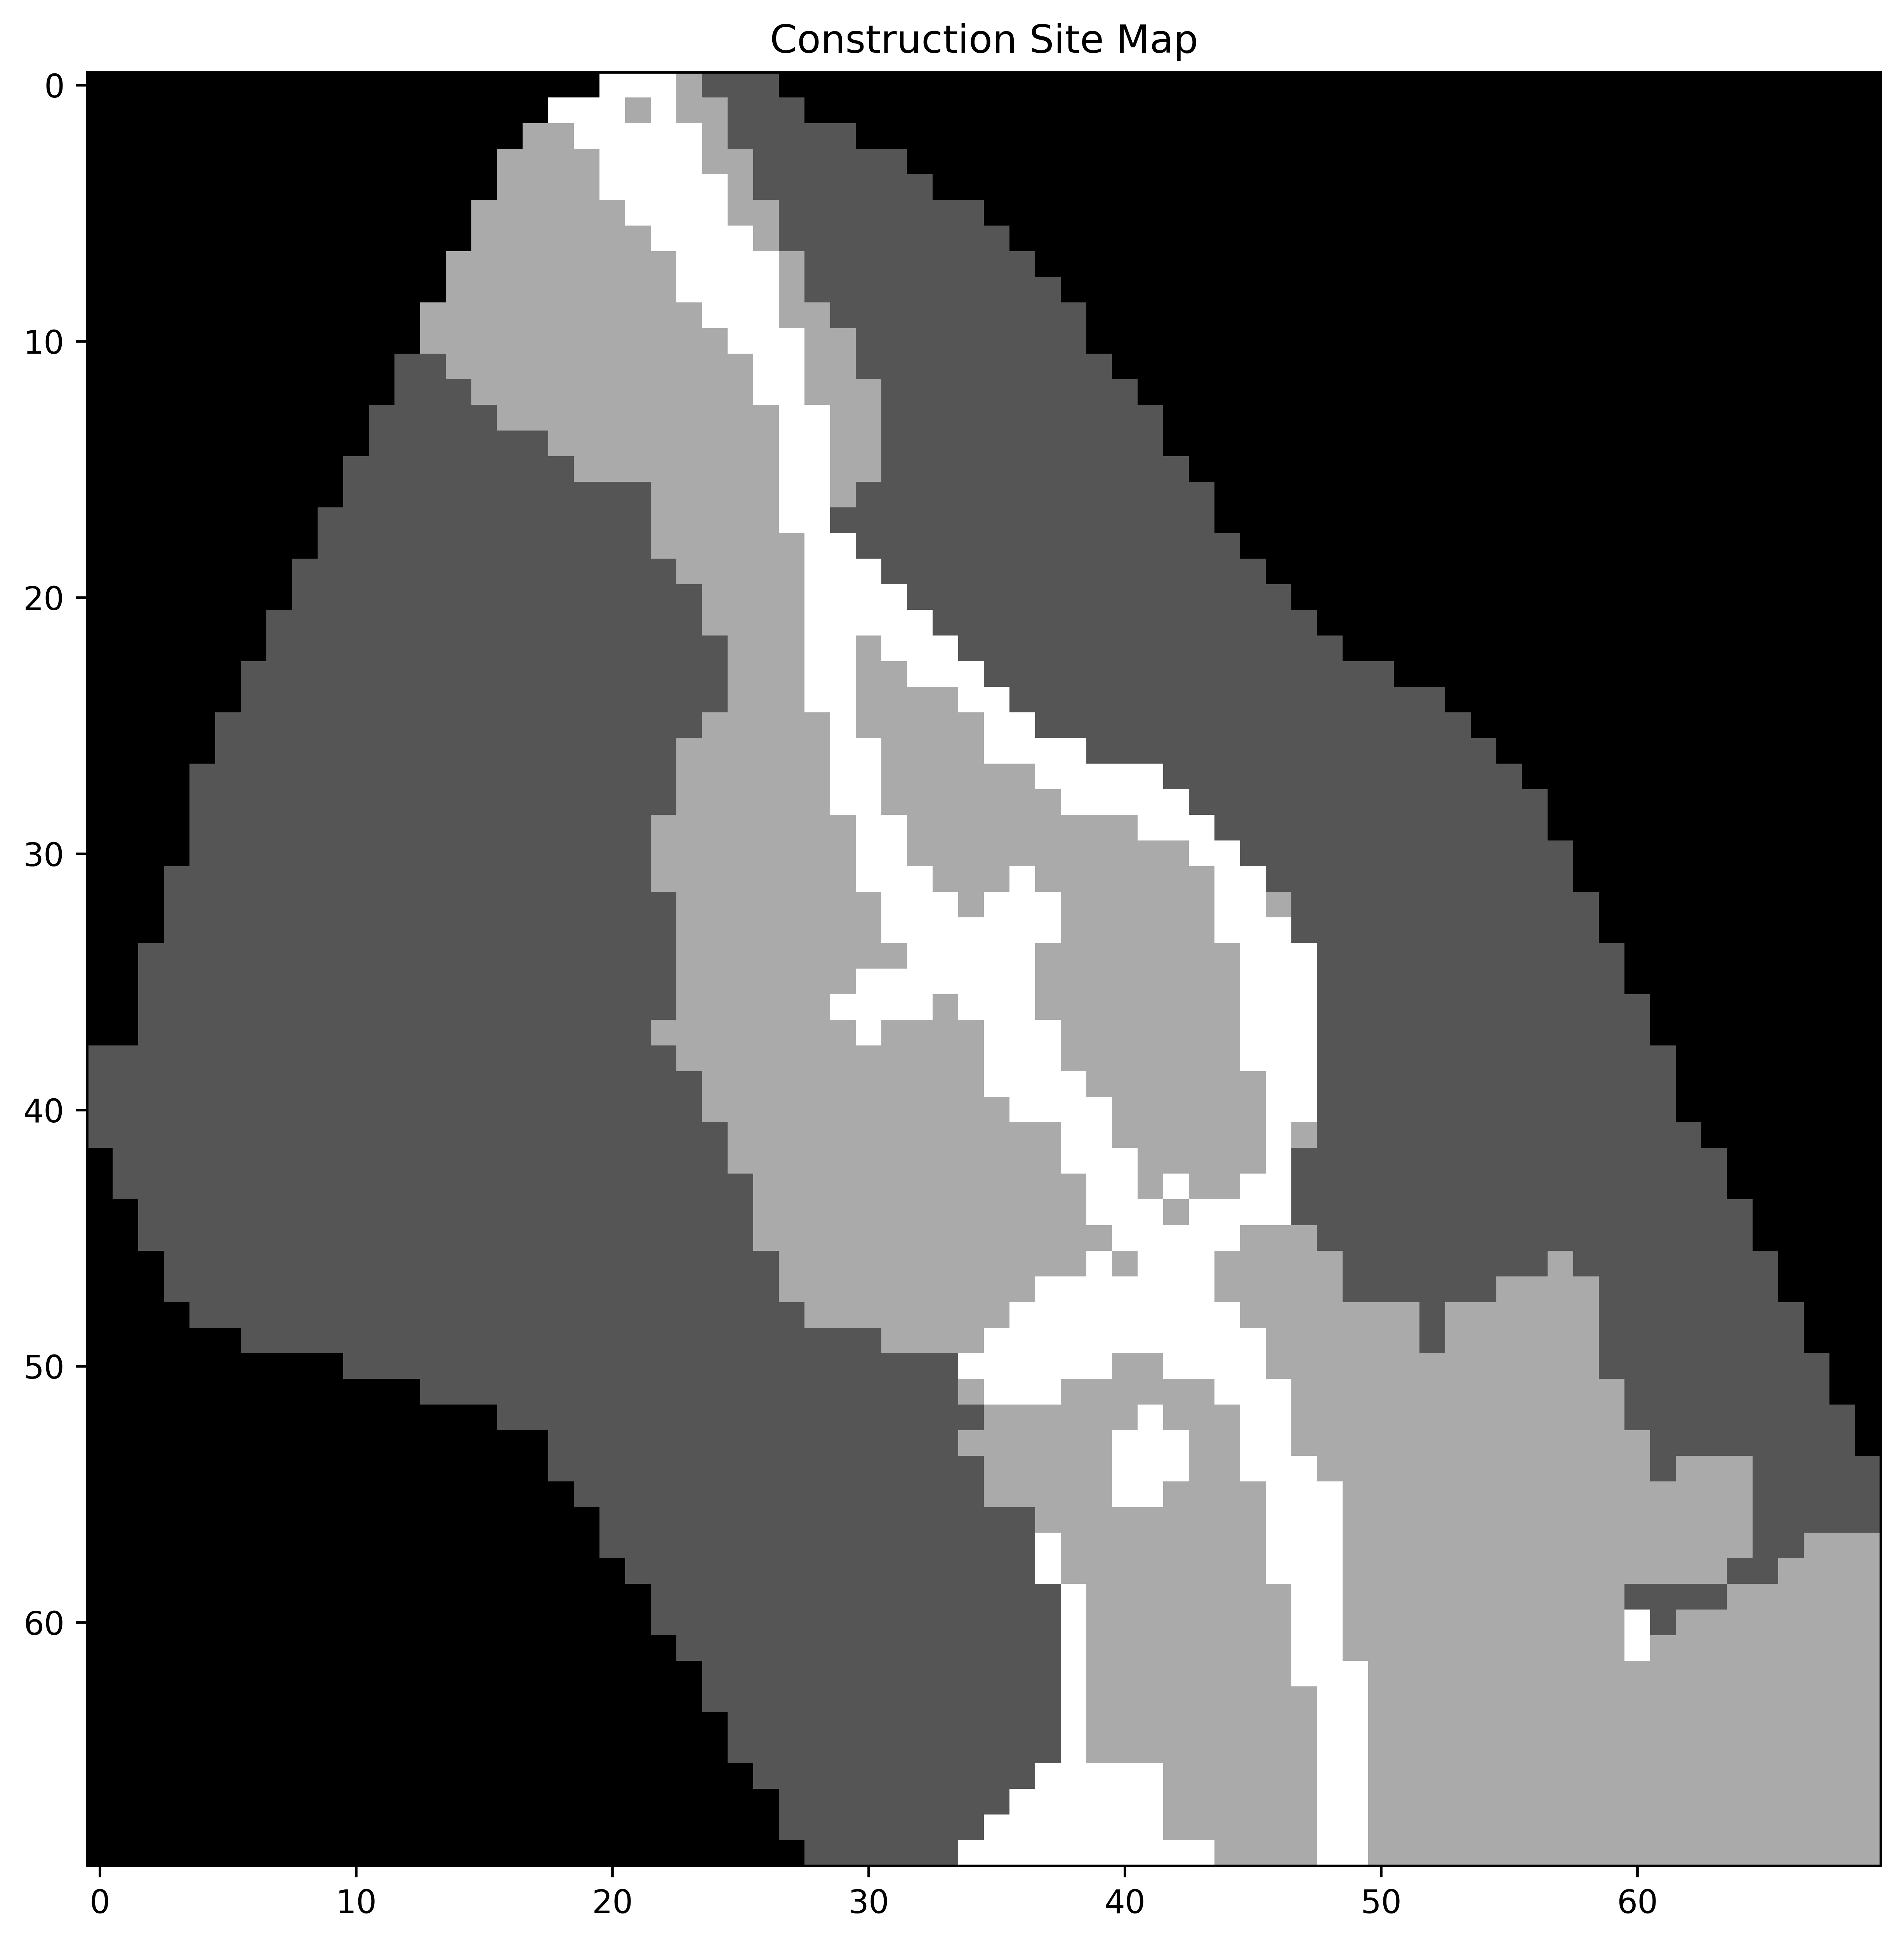

Saved figure: __RESULTS__/_plots/01-12-00-23/construction_map.png


In [4]:
vis.showMap(map_data=map, title="Construction Site Map", cmap='gray', filename="construction_map")

Installable map
<br><sub> A binary grid mask that defines physically feasible sensor deployment locations on the site. </sub>

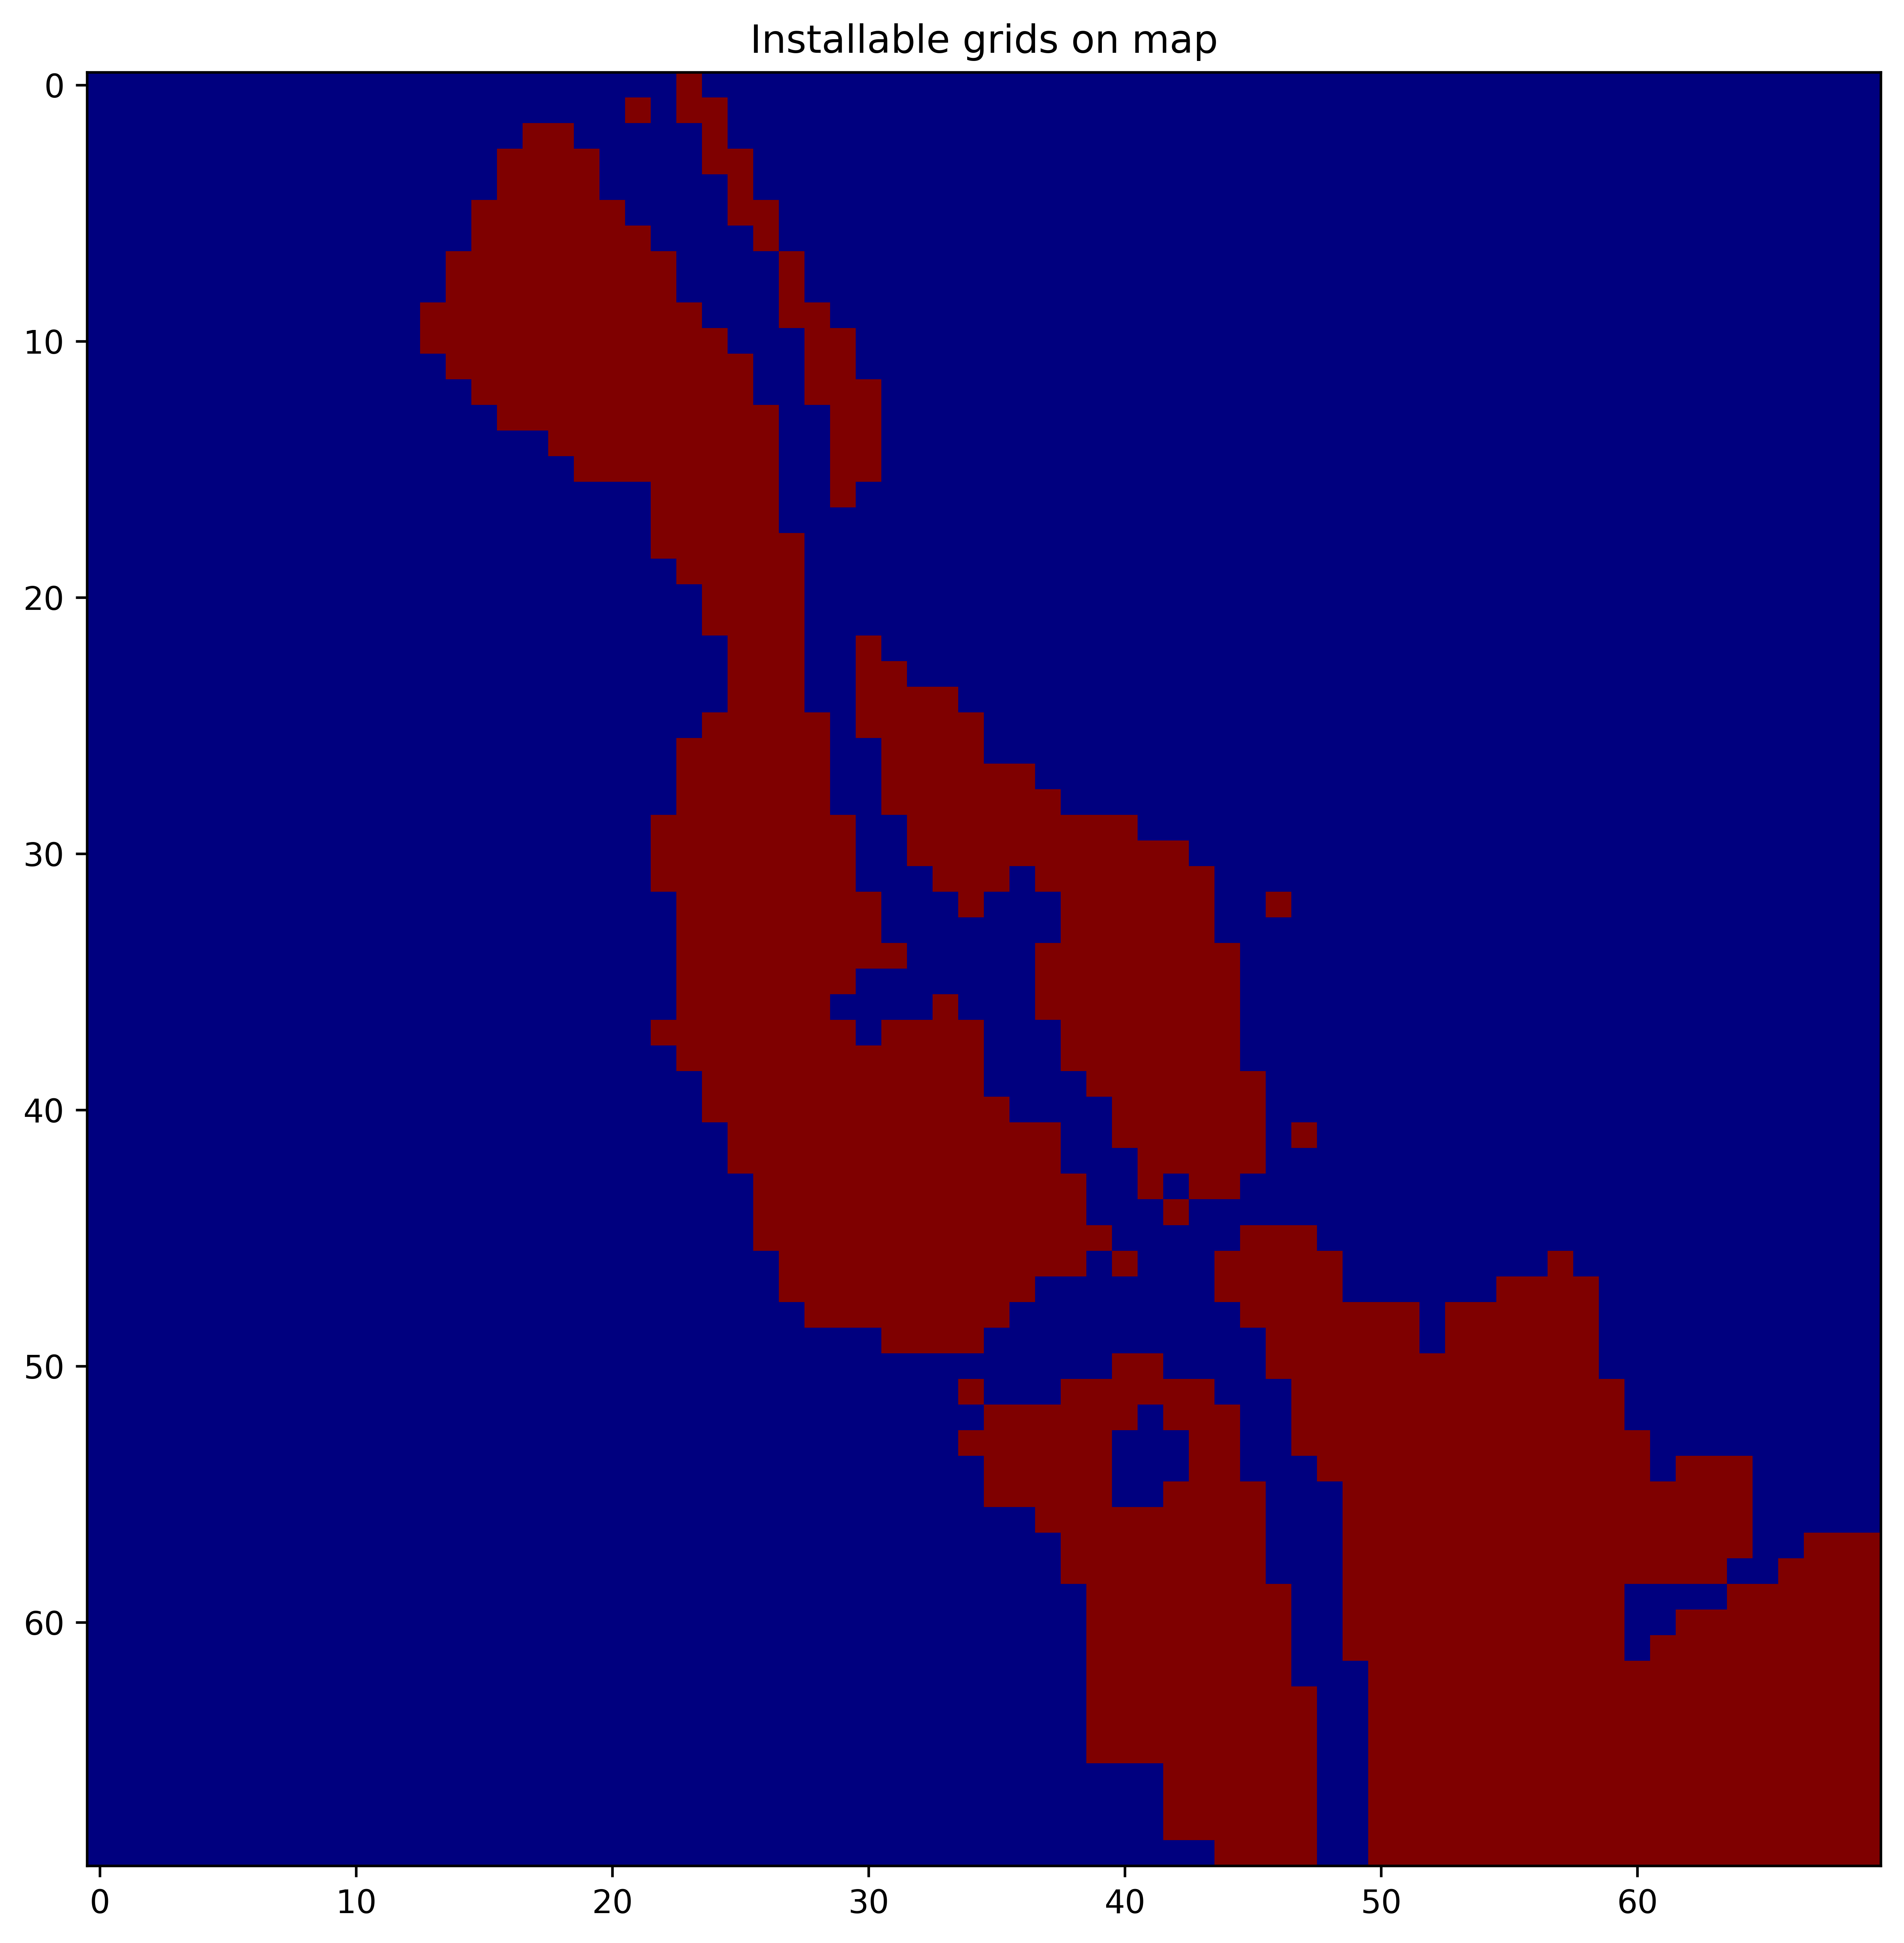

Saved figure: __RESULTS__/_plots/01-12-00-23/installable_map.png


In [5]:
installable_layer = layer_map(map, keep_values=[2])
vis.showMap(map_data=installable_layer, title="Installable grids on map", cmap='jet', filename="installable_map")

Uninstallable map
<br><sub>Regions excluded from sensor deployment due to safety, accessibility, or operational constraints <br>(e.g., equipment routes, waterlogged areas, vegetation, and offices).</sub>

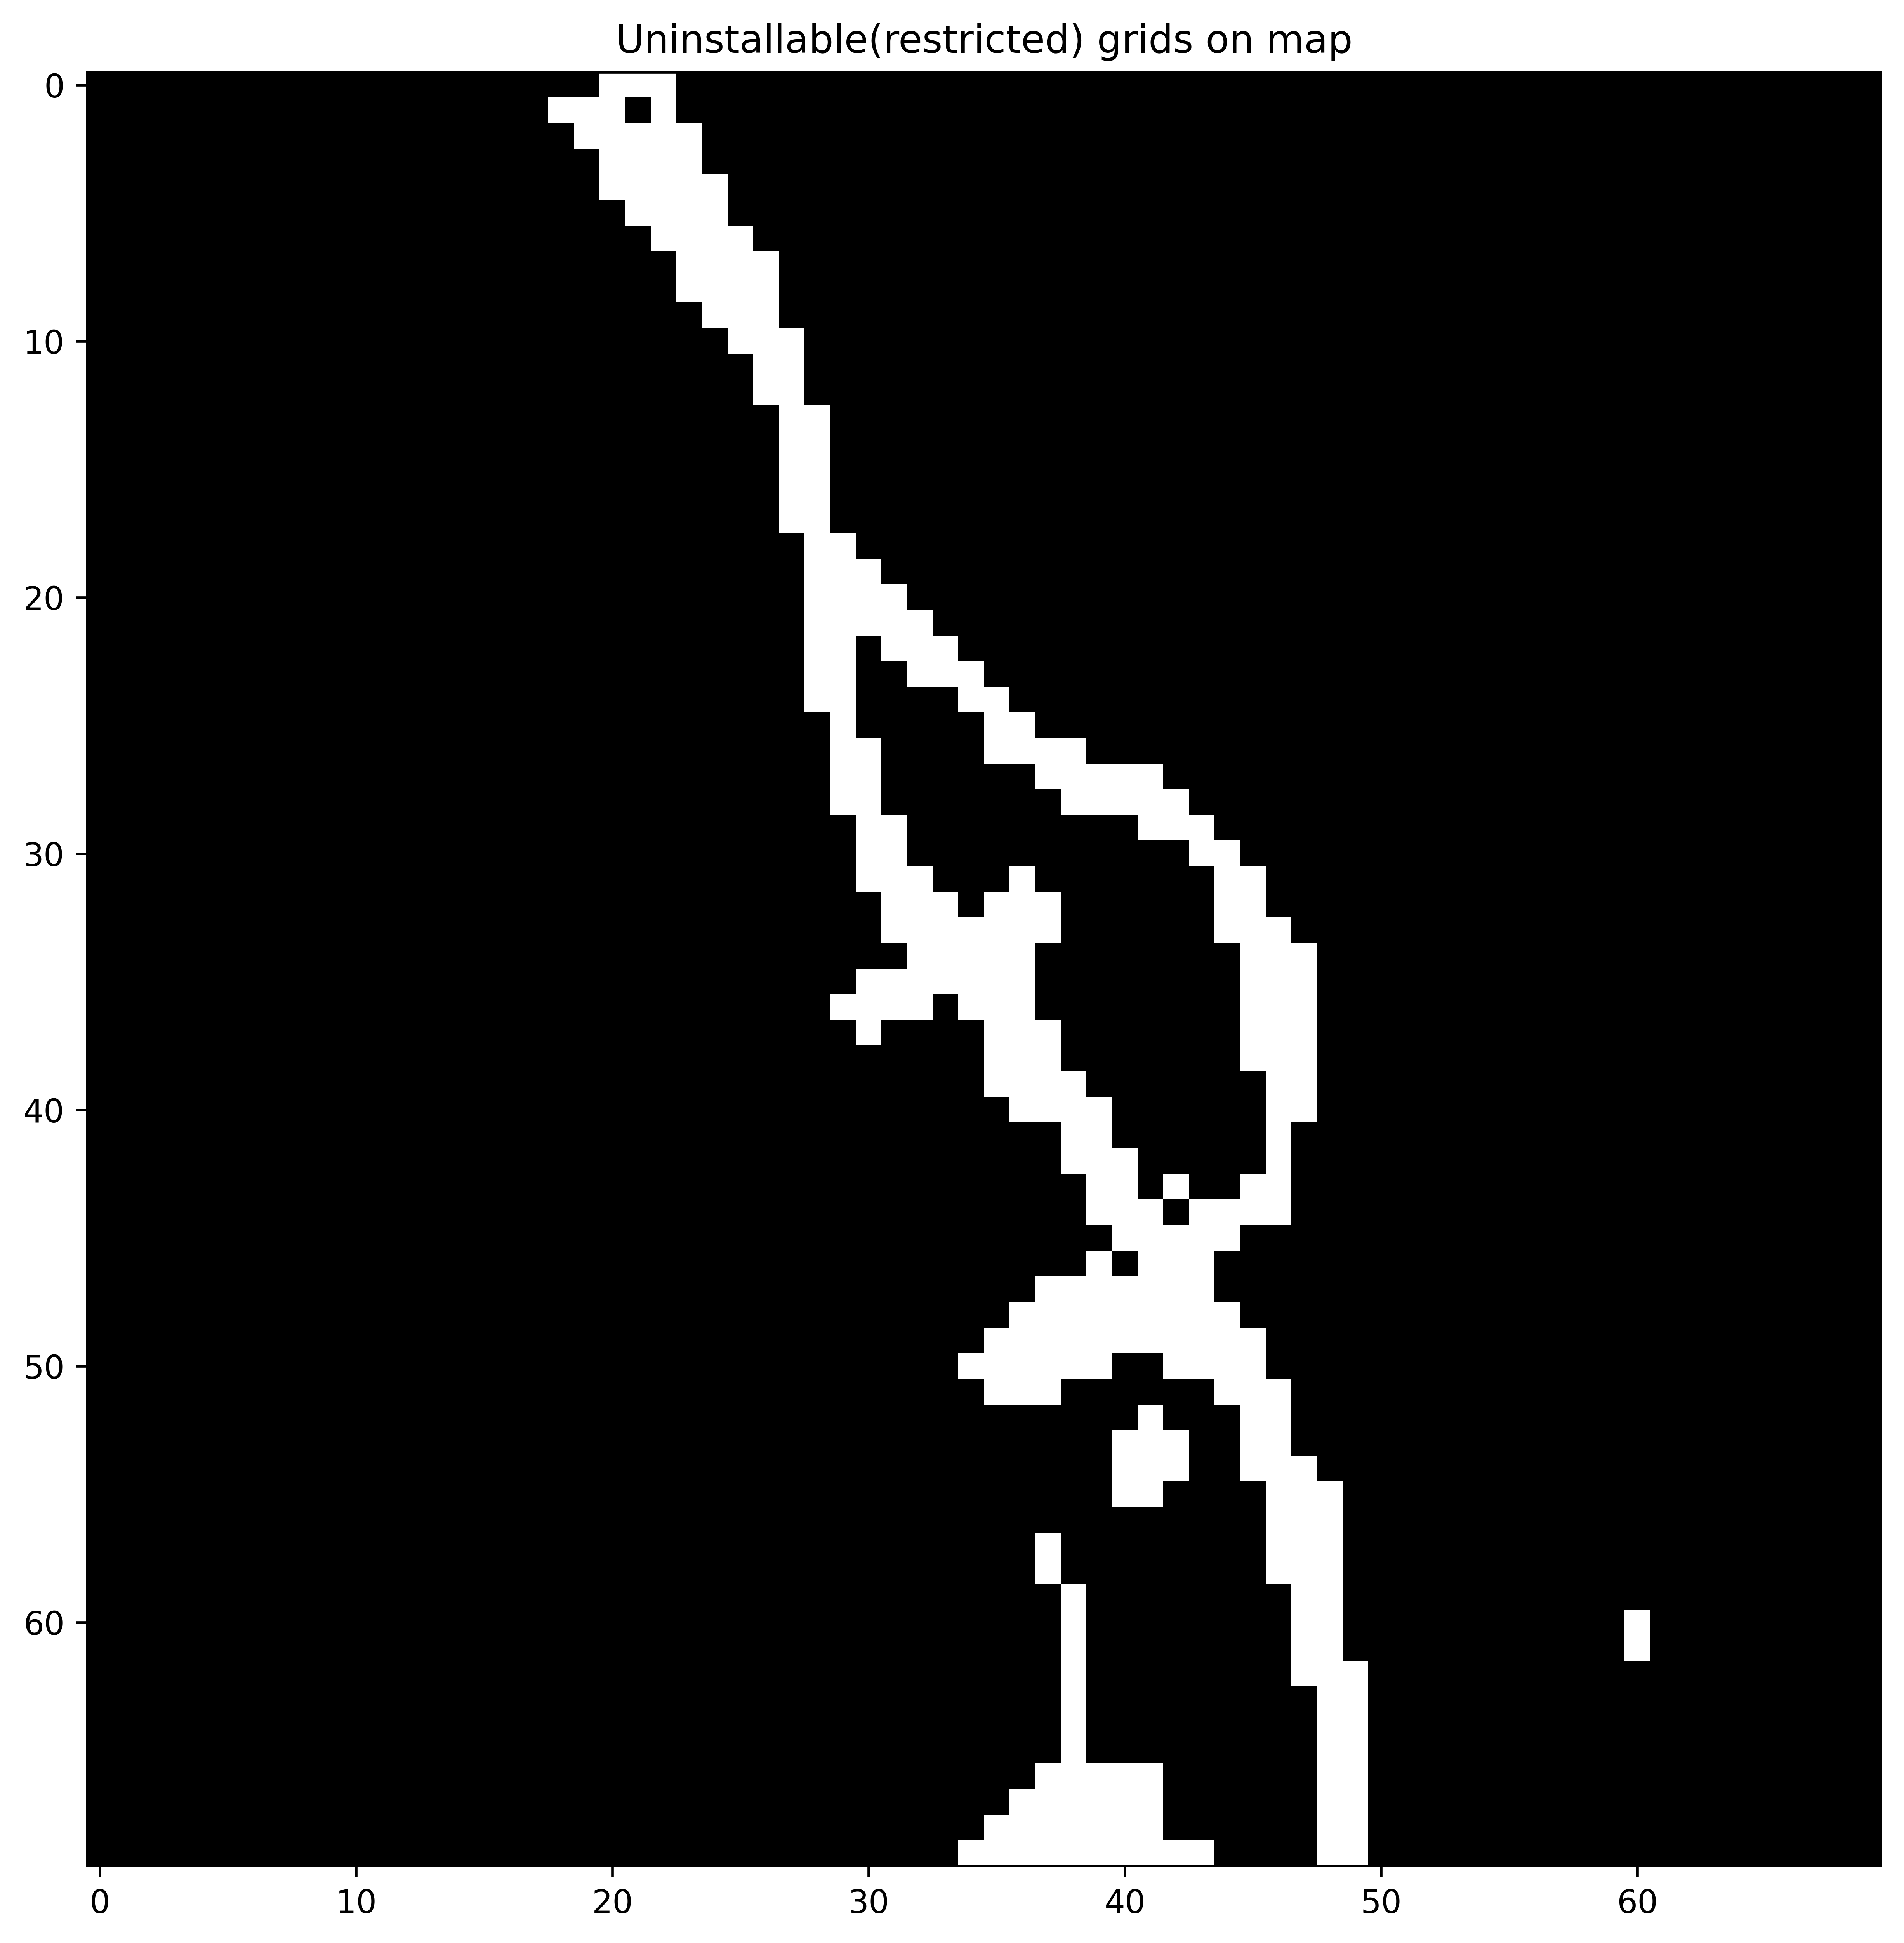

Saved figure: __RESULTS__/_plots/01-12-00-23/restricted__map.png


In [6]:
road_layer = layer_map(map, keep_values=[3])
vis.showMap(map_data=road_layer, title="Uninstallable(restricted) grids on map", cmap="gray", filename="restricted__map")

Jobsite area
<br><sub>The coverage target area for sensor deployment, defined as the union of installable and non-installable regions.</sub>

========== MAP CHECK ==========
Map shape (H,W): 70 x 70
Grid size: 5.0m x 5.0m  |  Cell area: 25.0 m^2
--------------------------------
Total cells: 4,900
Total area : 122,500.00 m^2  |  12.2500 ha  |  0.122500 km^2
--------------------------------
Target value      : 1
Target area       : 36,425.00 m^2  |  3.6425 ha  |  0.036425 km^2
Target cells      : 1,457  (29.73%)
--------------------------------
Value counts (entire map):
  - value 0: 3,443 (70.27%)
  - value 1: 1,457 (29.73%)


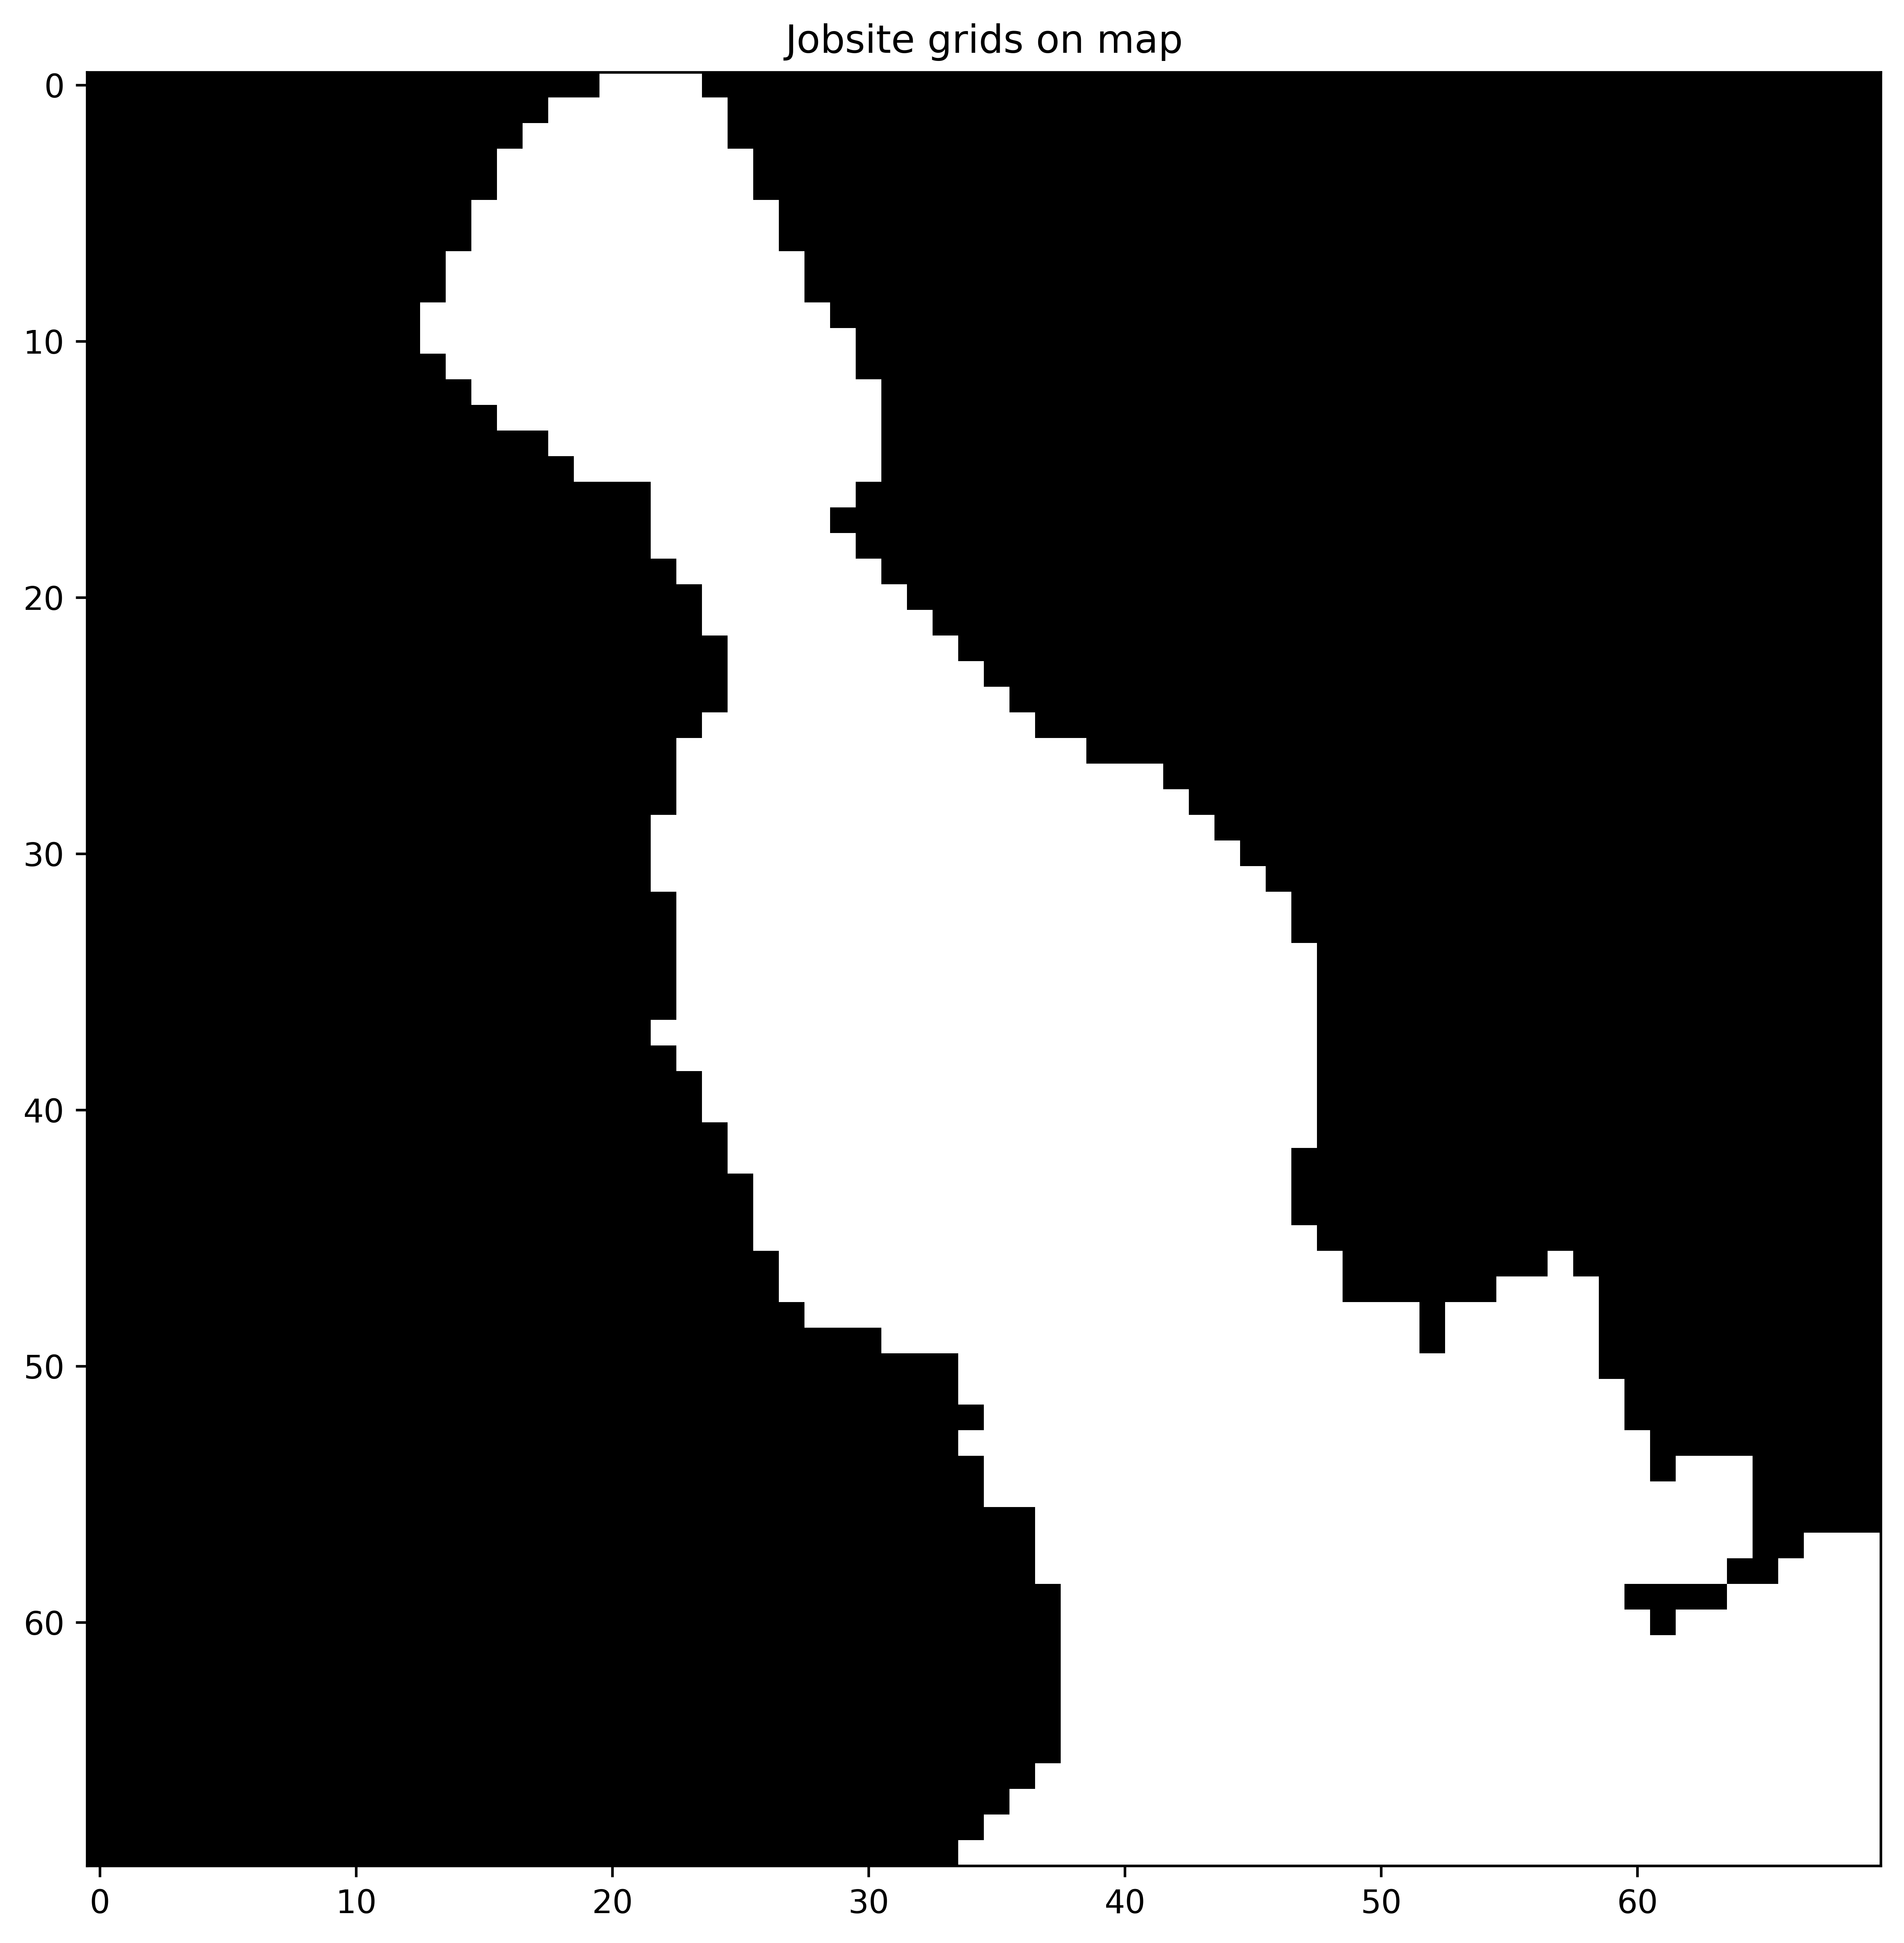

Saved figure: __RESULTS__/_plots/01-12-00-23/map_check.png


In [7]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.map_check(map_data=jobsite_layer,title="Jobsite grids on map", return_stats=False, cmap="gray")

### Systematic sensor deployment

In [8]:
#Set sensor coverage radius
COVERAGE = 45

Outermost corner location candidate extraction
<br><sub> Detection of outermost feasible sensor placement candidates within installable regions, since environmental sensing modules must be deployed at the site boundaries to capture extreme conditions. </sub>

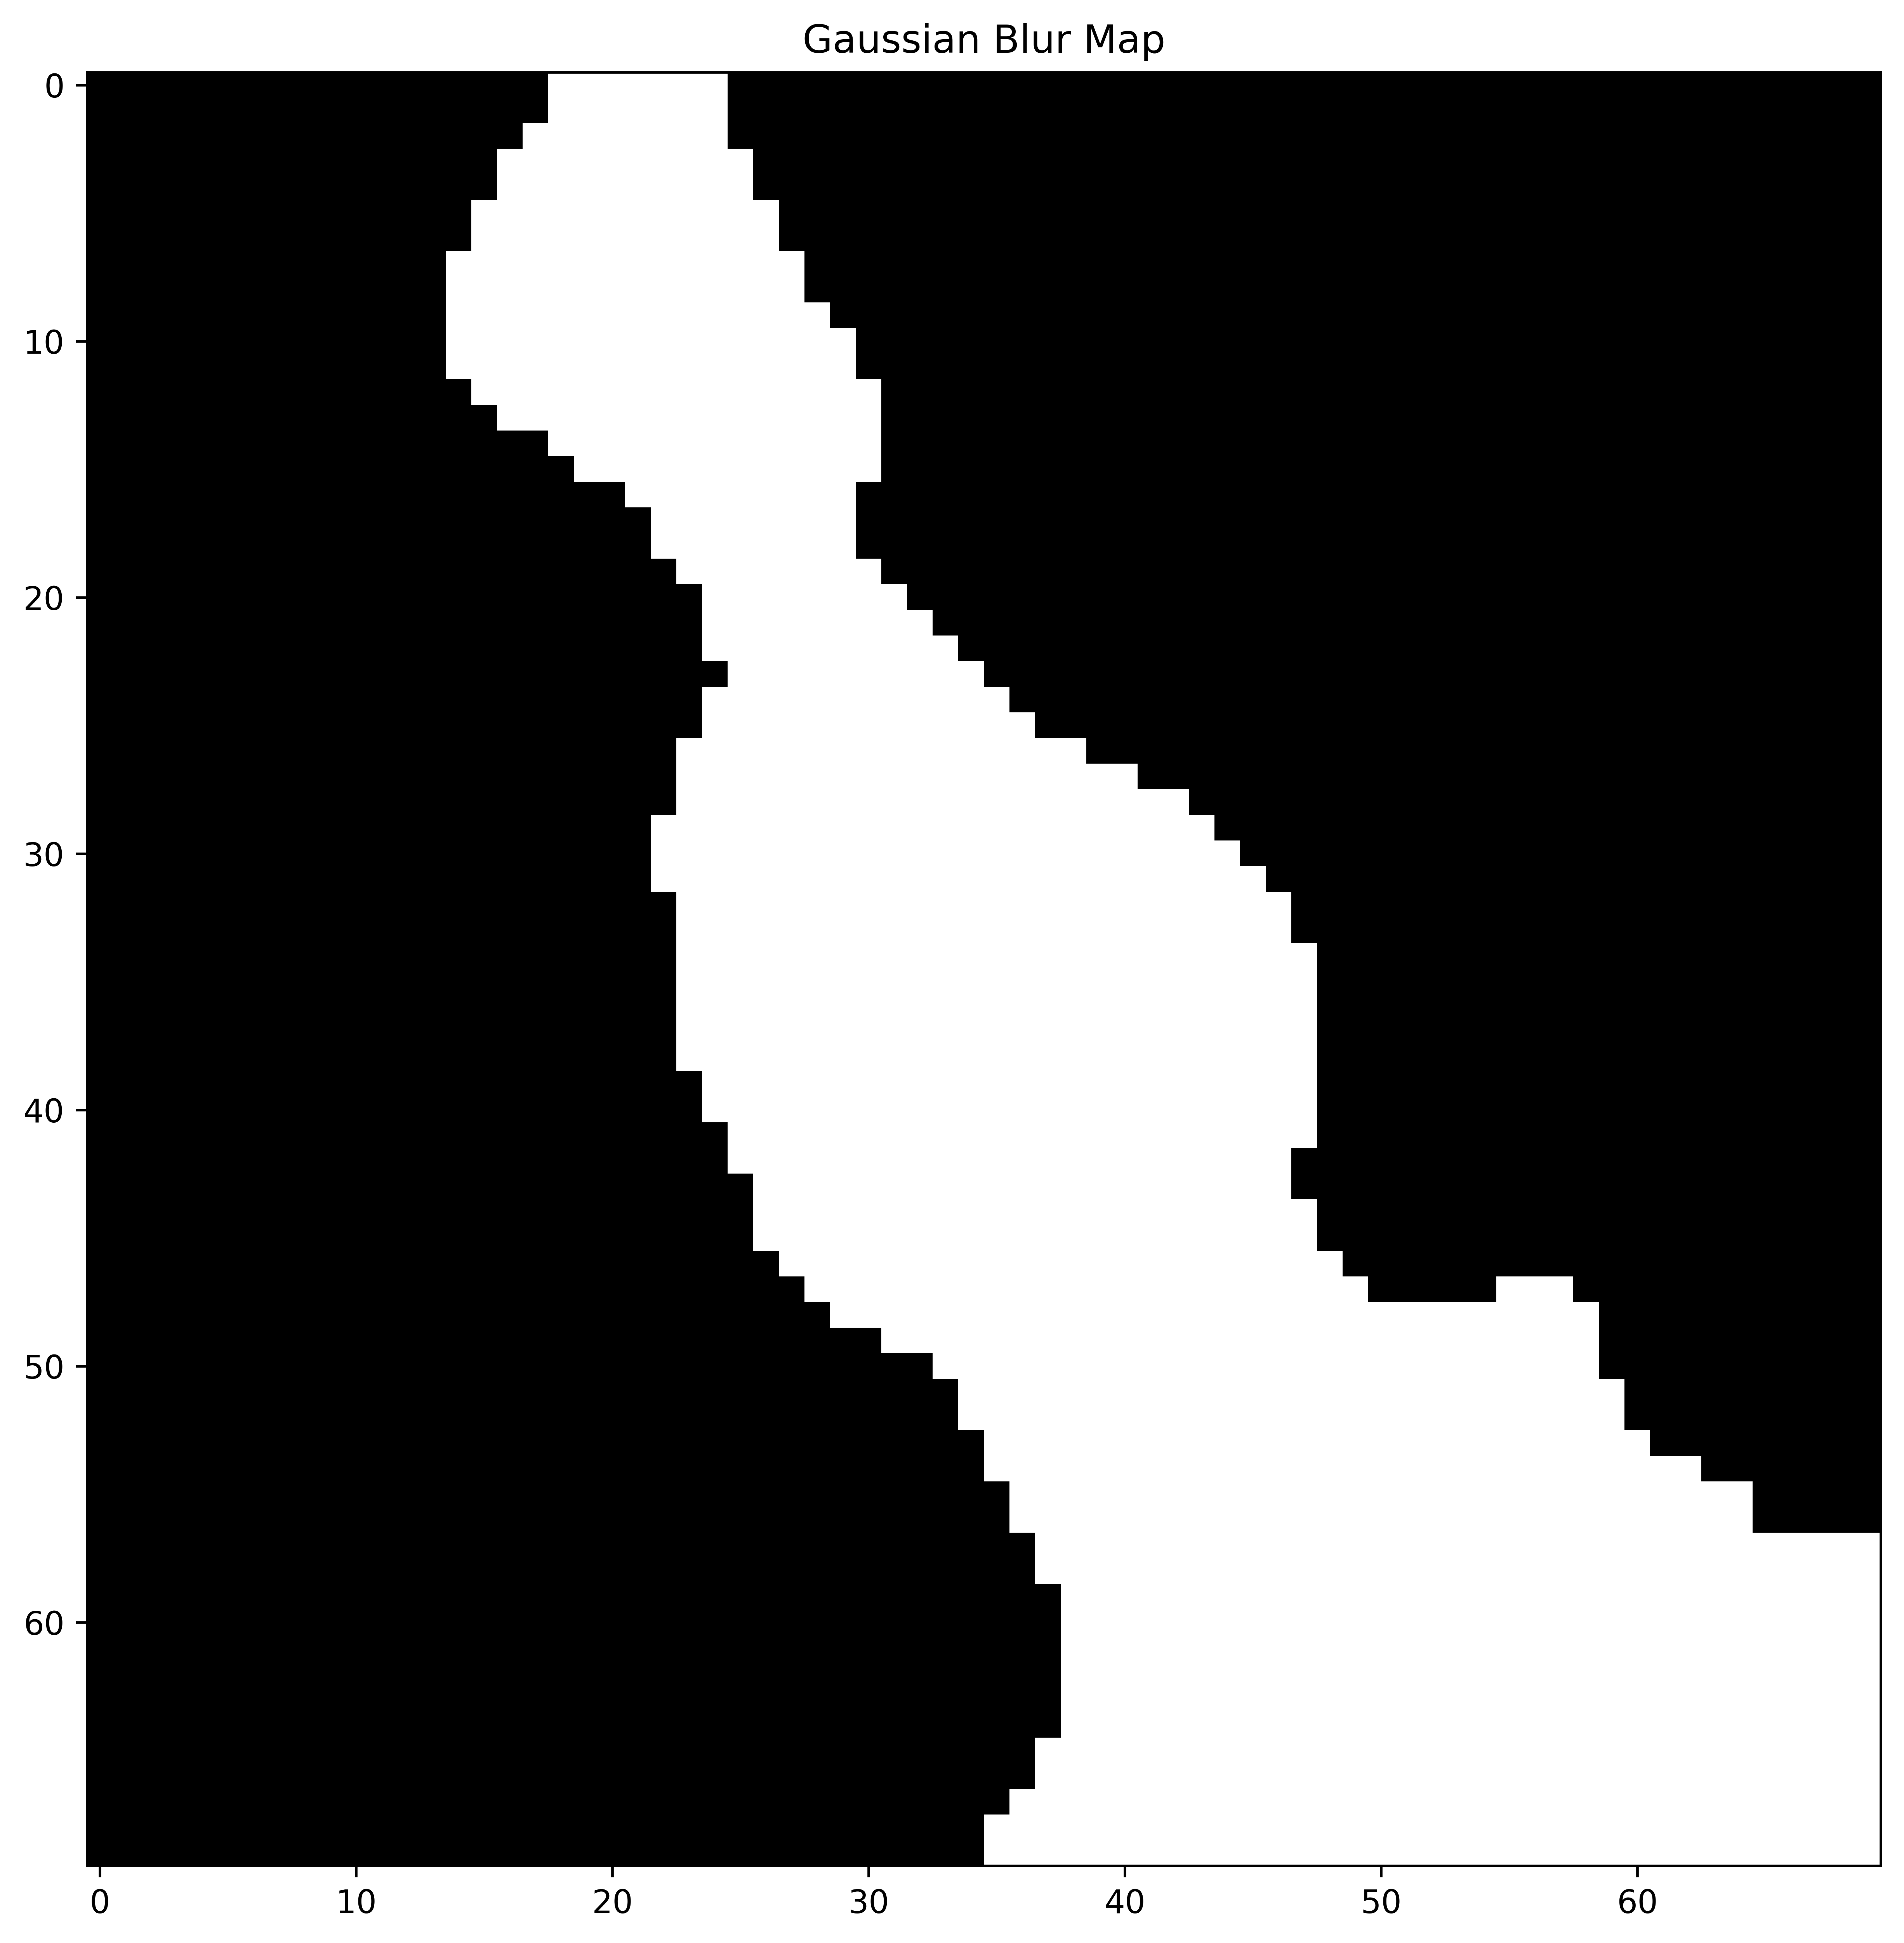

Saved figure: __RESULTS__/_plots/01-12-00-23/gaussian_blur_map.png


In [9]:
from OuterDeployment.HarrisCorner import HarrisCorner

corner_instance = HarrisCorner(jobsite_layer)

blur_map = corner_instance.gaussianBlur(grid=jobsite_layer)
vis.showMap(map_data=blur_map, title="Gaussian Blur Map", cmap='gray', filename="gaussian_blur_map")

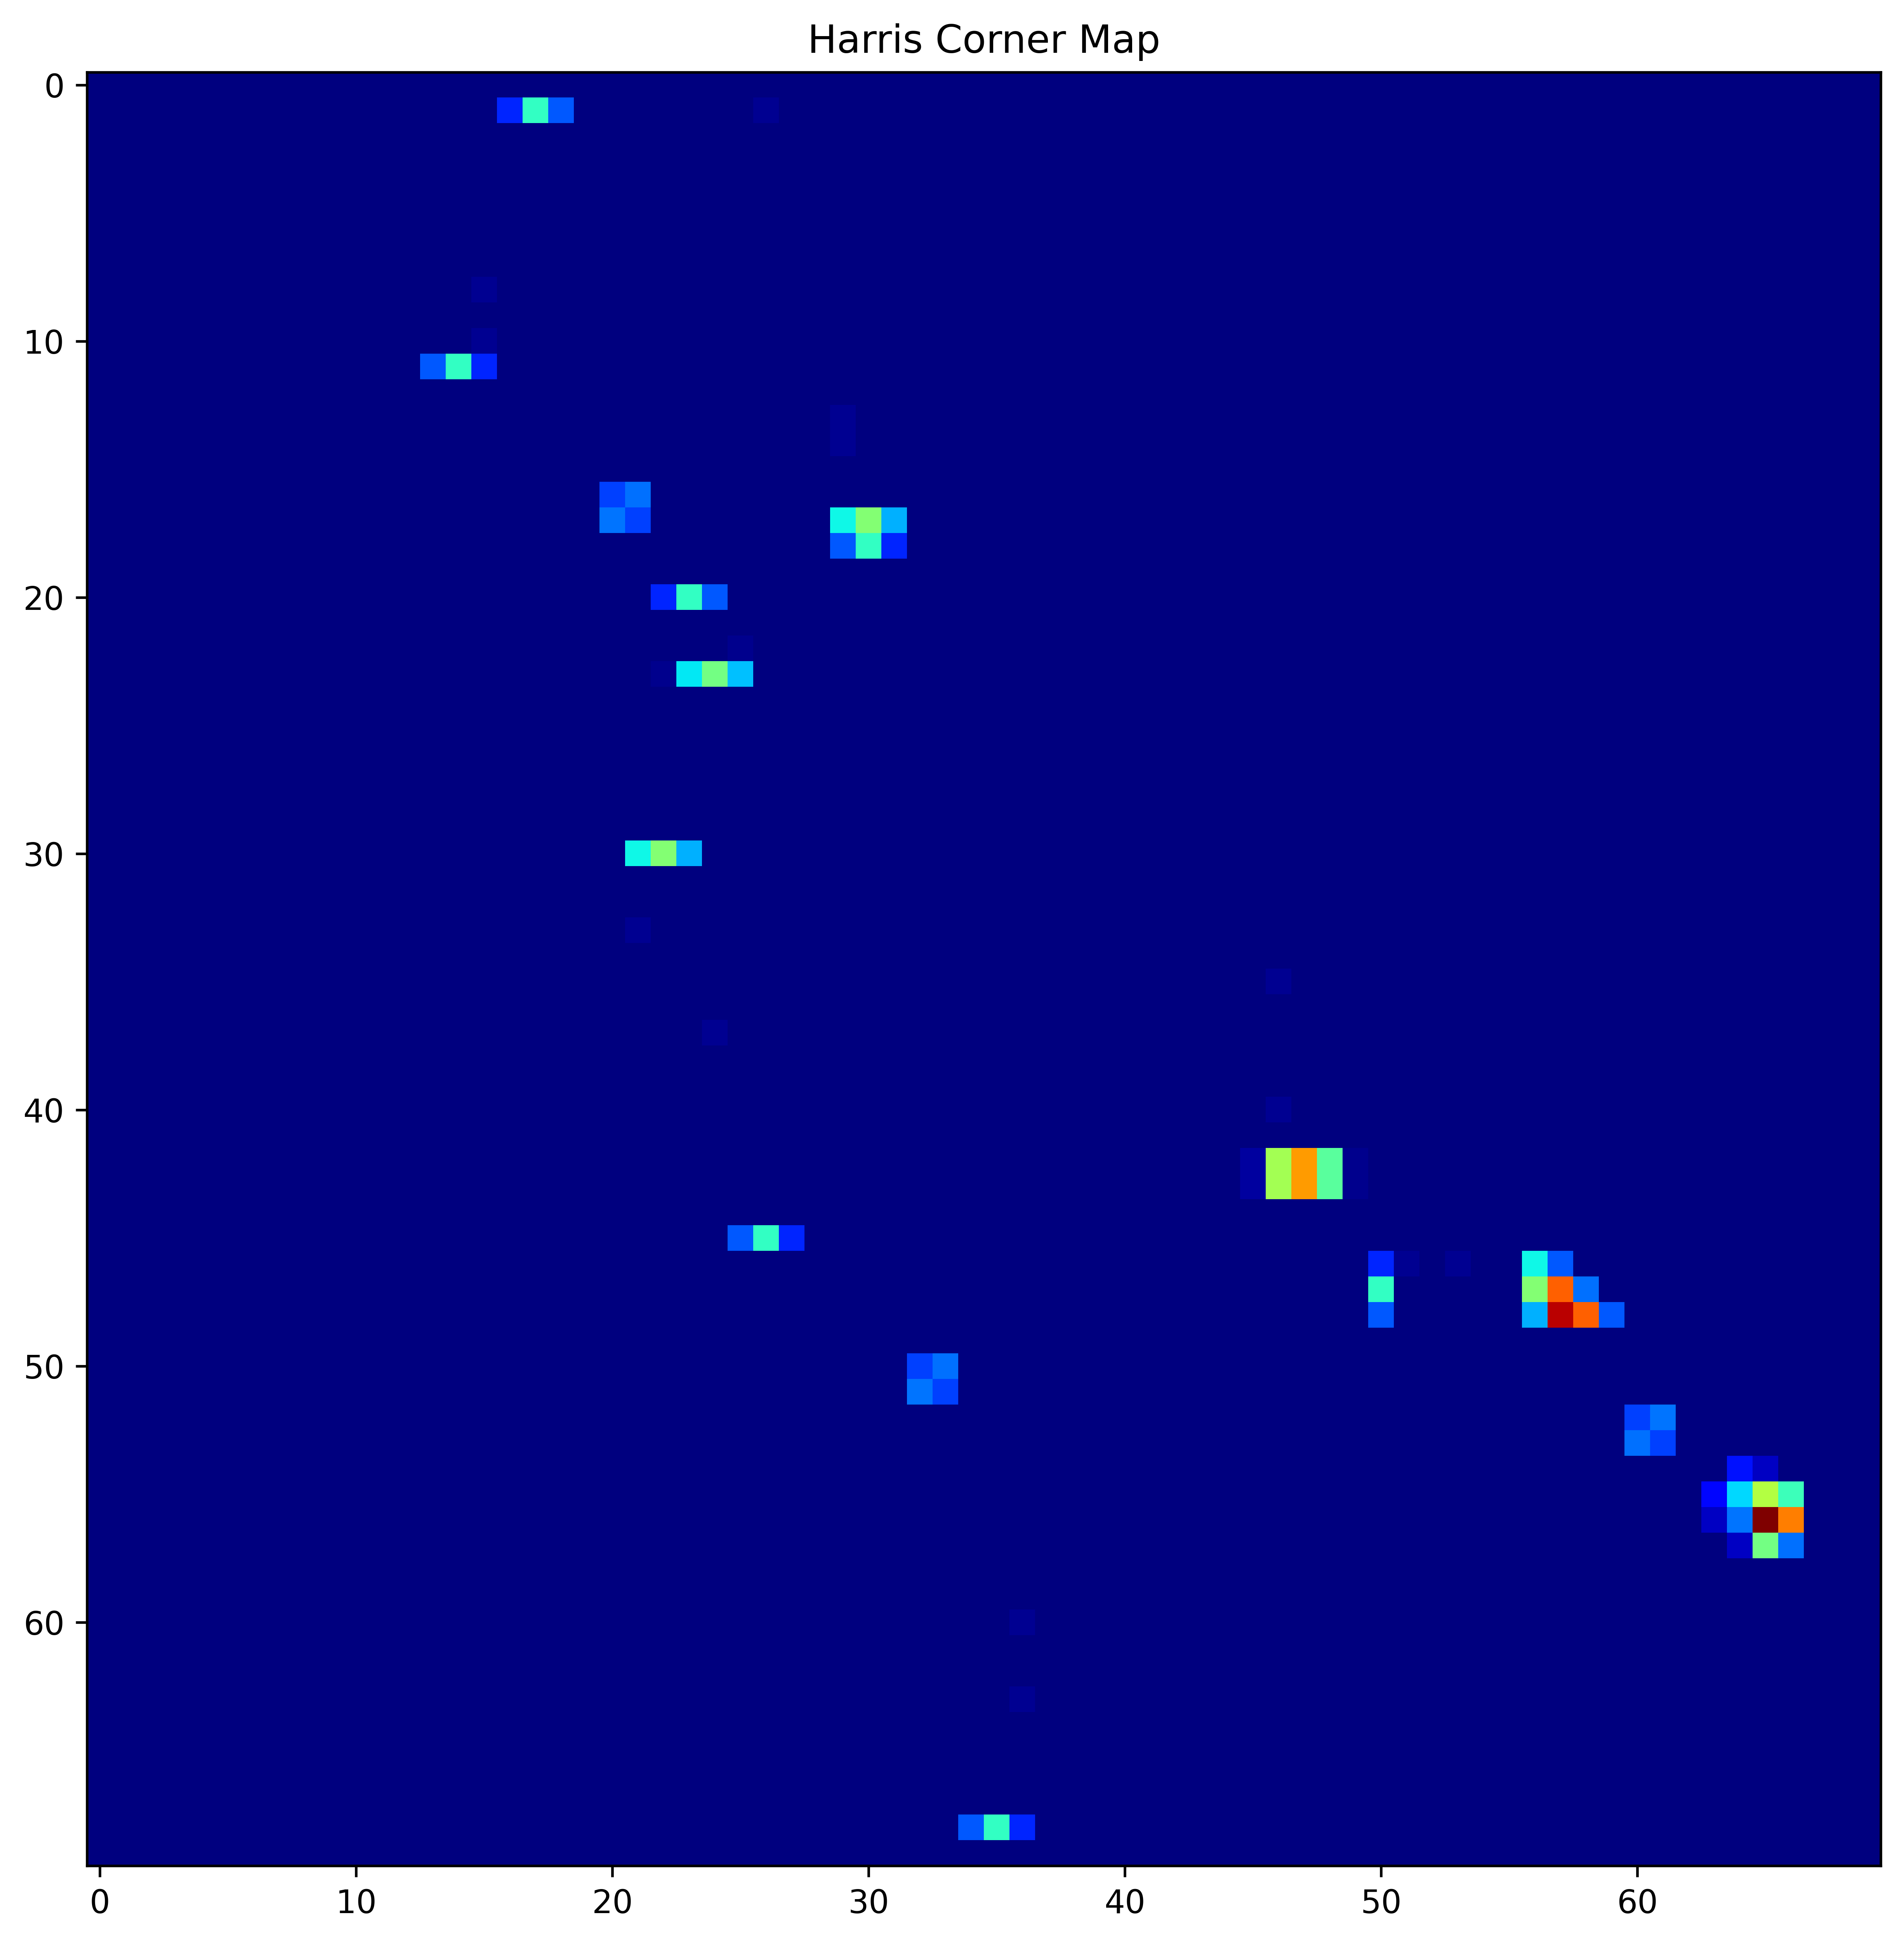

Saved figure: __RESULTS__/_plots/01-12-00-23/harris_corner_map.png


In [10]:
corner_heatmap = corner_instance.harrisCorner(
                                                grid=blur_map,
                                                block_size=3,
                                                ksize=3,
                                                k=0.05
                                                )
vis.showMap(map_data=corner_heatmap, title="Harris Corner Map", cmap="jet", filename="harris_corner_map")

Total outermost sensors : 4


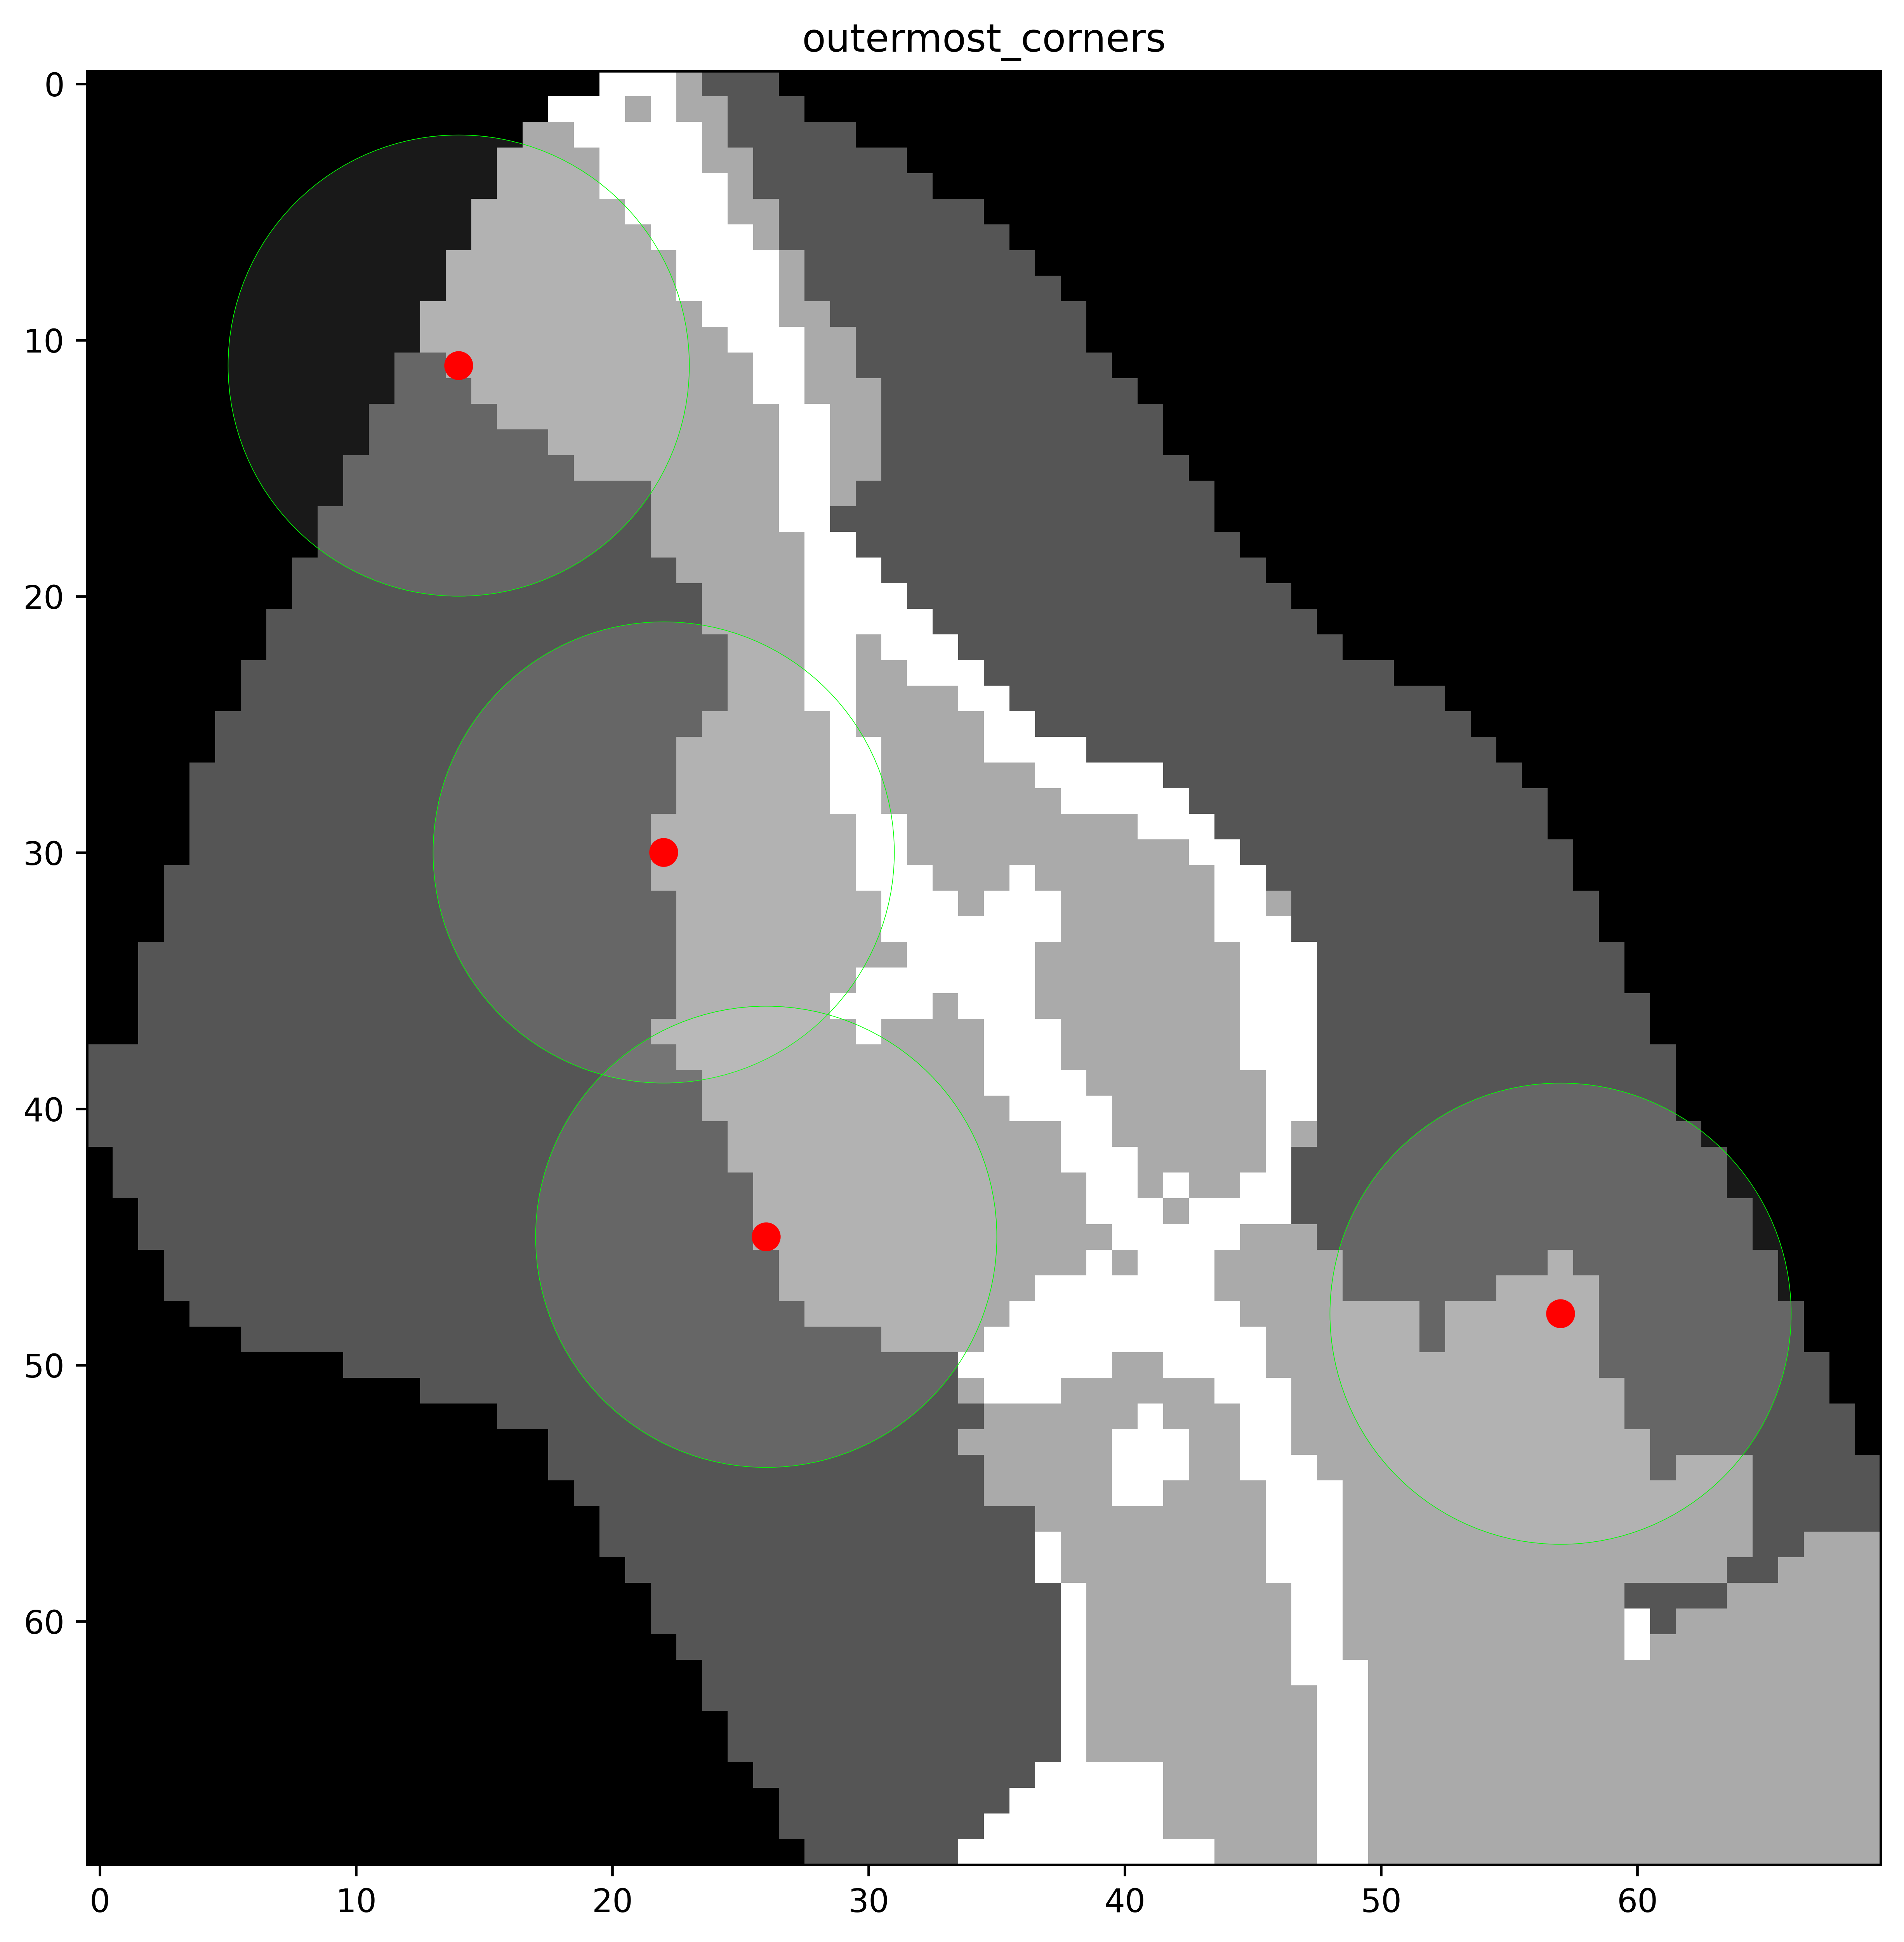

Saved figure: __RESULTS__/_plots/01-12-00-23/corner_sensors.png


In [11]:
corners = corner_instance.LMX(harris_map=corner_heatmap, installable_map=installable_layer, )

print("Total outermost sensors :",len(corners))
vis.showMap_circle(
    map_data=map, 
    sensor_positions=corners, 
    title="outermost_corners",
    cmap="gray",
    filename="corner_sensors"
    )

Outmost corner points: 4


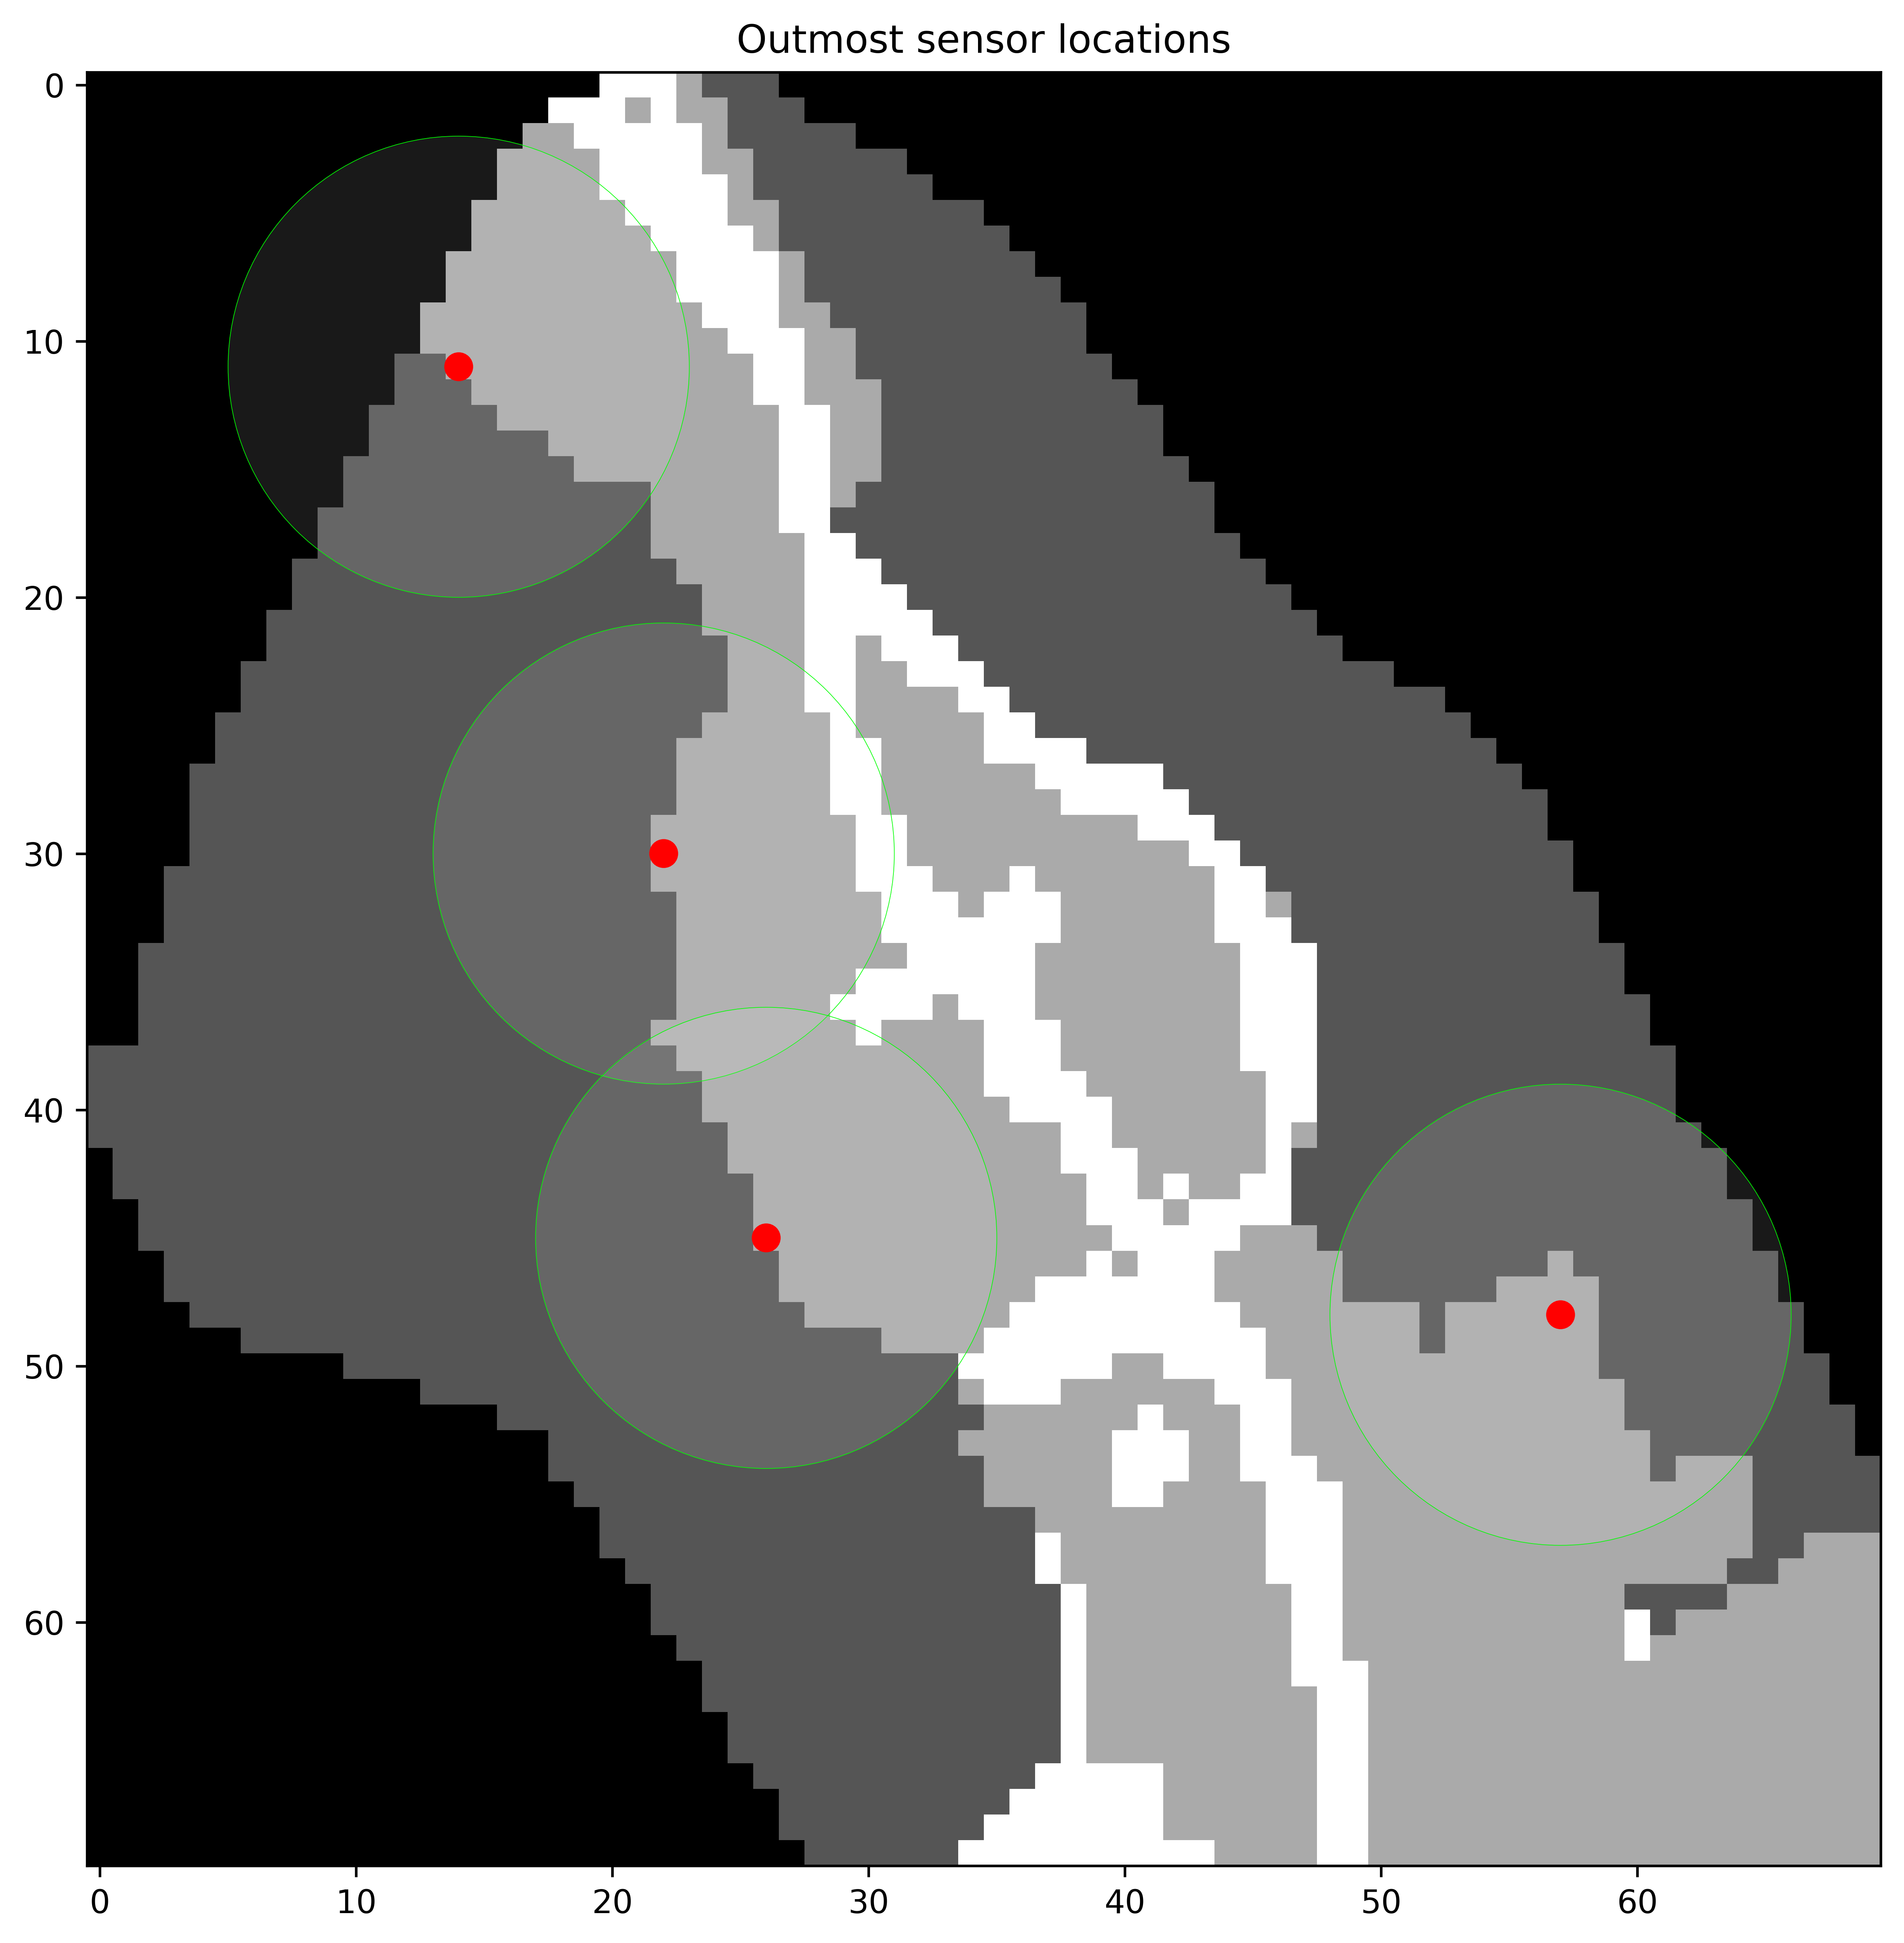

Saved figure: __RESULTS__/_plots/01-12-00-23/corner_sensors.png


In [12]:
corner_layer = HarrisCorner(jobsite_layer)
corner_candidate = corner_layer.run(
    grid=jobsite_layer,                
    installable_layer=installable_layer, 
    blockSize=3,
    ksize=3,
    k=0.05,
    dilate_size=5,
    min_dist=5,
)

print("Outmost corner points:", len(corner_candidate))
vis.showMap_circle(map_data=map, sensor_positions=corner_candidate, title="Outmost sensor locations",radius=COVERAGE, cmap='gray', filename="corner_sensors")

Inner-Deployment Strategy: Genetic Algorithm
<br><sub>Genetic Algorithm is used to optimize the placement of inner sensors, minimizing the number of sensors while ensuring sufficient coverage of the jobsite area. </sub>

In [13]:
from InnerDeployment.GeneticAlgorithm.main import SensorGA

ga = SensorGA(
                installable_map=installable_layer,
                jobsite_map=jobsite_layer,
                coverage=COVERAGE,
                generations=100,
                corner_positions=corner_candidate,
                initial_size=100,
                selection_size=50,
                child_chromo_size=100,
                min_sensors=50,
                max_sensors=100,
            )

optimized_result = ga.run(
                    selection_method="tournament",
                    mutation_rate=0.7,
                    early_stop=True,
                    early_stop_coverage=90.0,
                    early_stop_patience=5,
                    return_best_only=True
                )

KeyboardInterrupt: 

In [ ]:
print("[FINALIZE OUTPUT] ga.best_solution =", ga.best_solution)
print("[FINALIZE OUTPUT] len(ga.best_solution) =", len(ga.best_solution))
print("[FINALIZE OUTPUT] ga.corner_points =", ga.corner_points)
print("[FINALIZE OUTPUT] len(ga.corner_points) =", len(ga.corner_points))

In [ ]:
final_result = optimized_result + corner_candidate
print("Total number of Sensor :", len(final_result))
vis.showMap_circle(
    map_data=map, 
    sensor_positions=final_result,
    title="Final Sensor Locations after Optimization",
    radius=COVERAGE,
    cmap='gray',
    filename="final_sensors"
    )